# Определение возраста покупателей

## Исследовательский анализ данных

Размер выборки: 7591 образцов


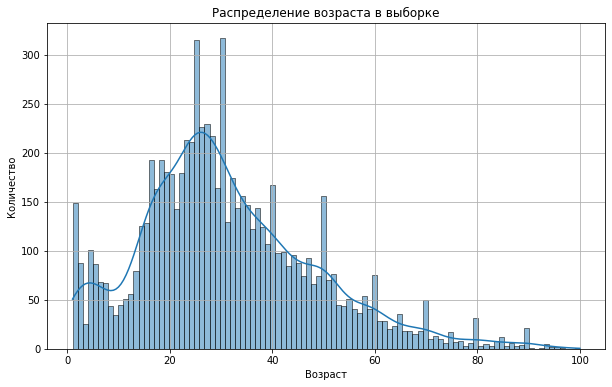

Found 7591 validated image filenames.


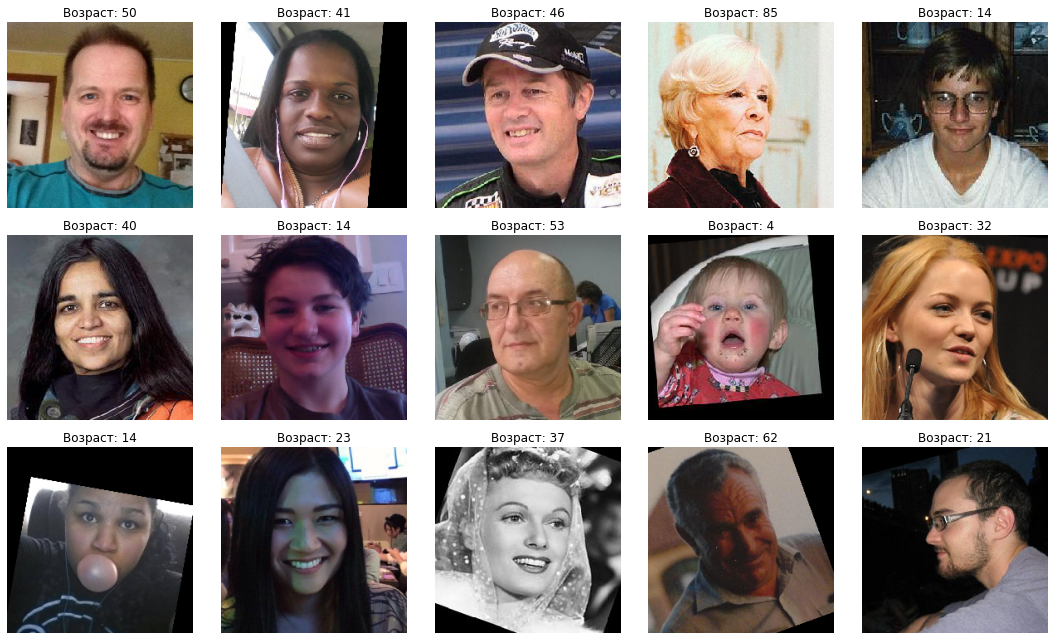

       file_name  real_age
6117  006120.jpg        45
6645  006650.jpg        30
1218  001218.jpg        30
1913  001913.jpg        24
5108  005108.jpg        32


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Загрузка данных
labels = pd.read_csv('/datasets/faces/labels.csv')

# Посмотрим на размер выборки
print(f"Размер выборки: {labels.shape[0]} образцов")

# График распределения возраста
plt.figure(figsize=(10, 6))
# sns.histplot(labels['real_age'], bins=30, kde=True)
sns.histplot(labels['real_age'], bins=100, kde=True) # РЕВЬЮЕР: так получше :)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid(True)
plt.show()

# Генератор данных для загрузки изображений
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

# Вывод 10–15 фотографий из датасета
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()
images, ages = next(train_gen_flow)

# Отображение изображений с заголовками возраста
for img, age, ax in zip(images[:15], ages[:15], axes):
    ax.imshow(img)
    ax.set_title(f"Возраст: {int(age)}")
    ax.axis('off')

plt.tight_layout()
plt.show()

print(train_gen_flow)

print(labels.sample(5))

**Выводы**

**1. Размер выборки:**
- Общее количество образцов: 7591

**2. График распределения возраста:**
- Гистограмма с наложенной линией плотности показывает,\
что большинство образцов в наборе данных сосредоточены в диапазоне от 0 до 40 лет. \
Пик приходится на возрастную группу около 25-30 лет, после чего наблюдается постепенное снижение числа образцов с увеличением возраста. \
Этот график указывает на возможный дисбаланс в данных, так как возрастные группы старше 50 лет представлены значительно меньше.

**3. Пример фотографий из набора данных:**
- На изображениях видно разнообразие в возрасте, расе и поле. \
Также присутствует различие в условиях освещения, позах и выражениях лиц,\
что говорит о высоком уровне разнообразия в наборе данных.\
Однако, важно отметить, что все изображения не идеально выровнены, и на некоторых есть повороты.

**4. Дисбаланс в возрастных группах:** 
- Большая часть данных сосредоточена в молодом и среднем возрасте (до 40 лет).\
Недостаточное представление старших возрастных групп может привести к тому,\
что модель будет плохо обобщать на этой возрастной группе.\
Для борьбы с этим можно рассмотреть применение техники аугментации данных или использование взвешенных потерь,\
чтобы уделить больше внимания менее представленным группам.

**5. Разнообразие данных:** 
- Набор данных включает изображения с различными характеристиками, \
что является положительным фактором для обучения модели.\
Это помогает модели быть более устойчивой к изменениям условий съёмки, таким как освещение и поза.

**6. Неравномерность изображений:**
- Некоторое количество изображений не выровнено должным образом,\
что может вызвать дополнительные трудности при обучении модели.\
Возможно, следует рассмотреть предварительную обработку изображений для выравнивания лиц.

Эти выводы можно использовать для улучшения модели, включая пересмотр стратегии аугментации данных, использование более сложных архитектур для обработки разнообразных данных и дополнительную обработку изображений перед обучением модели.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout



def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
 
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(Dropout(0.1))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, 
                  loss='mean_squared_error',
                  metrics=['mae'])
    
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model
```

```

356/356 - 46s - loss: 61.4633 - mae: 5.9797 - val_loss: 110.6513 - val_mae: 8.5245
Epoch 4/10
356/356 - 46s - loss: 41.3828 - mae: 4.9175 - val_loss: 70.7799 - val_mae: 6.2209
Epoch 5/10
356/356 - 47s - loss: 30.3700 - mae: 4.2371 - val_loss: 80.3901 - val_mae: 6.7572
Epoch 6/10
356/356 - 47s - loss: 25.1416 - mae: 3.8279 - val_loss: 70.1076 - val_mae: 6.1608
Epoch 7/10
356/356 - 46s - loss: 19.2007 - mae: 3.3517 - val_loss: 82.3294 - val_mae: 7.0886
Epoch 8/10
356/356 - 47s - loss: 17.5517 - mae: 3.1840 - val_loss: 68.7183 - val_mae: 6.1612
Epoch 9/10
356/356 - 46s - loss: 15.0962 - mae: 2.9495 - val_loss: 68.0442 - val_mae: 6.2077
Epoch 10/10
356/356 - 47s - loss: 12.4917 - mae: 2.7149 - val_loss: 64.6376 - val_mae: 6.0603
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 64.6376 - mae: 6.0603
Test MAE: 6.0603

```

## Анализ обученной модели

**1. Архитектура и настройки модели:**
- Модель основана на предобученной ResNet50 с весами `imagenet` и исключением верхних слоев (`include_top=False`).
- Дополнительно добавлены слои:
  - `Dropout` (с вероятностью 0.1) для регуляризации.
  - `GlobalAveragePooling2D` для сведения признаков к фиксированному размеру.
  - Полносвязный слой с одним нейроном и активацией `ReLU` для регрессии (предсказание возрастов).
- Оптимизатор `Adam` с начальной скоростью обучения 0.0001.
- Функция потерь: `mean_squared_error` (MSE).
- Метрика: `mean_absolute_error` (MAE).

**2. Результаты обучения:**
- **MAE на тренировочной выборке:** снижается с каждой эпохой, что указывает на успешное обучение модели. Начиная с 5.9797 (первоначально) и снижаясь до 2.7149 к 10-й эпохе.
- **MAE на валидационной выборке:** также снижается, хотя и с меньшей скоростью. Начинается с 8.5245 и падает до 6.0603 к 10-й эпохе. 

**3. Выводы:**
- Модель демонстрирует успешное снижение ошибки на тренировочных данных, что указывает на способность модели обучаться.
- Ошибка на валидационной выборке также снижается, но сохраняется на более высоком уровне по сравнению с тренировочной выборкой, что может свидетельствовать о переобучении или недостаточной сложности модели.
- Для дальнейшего улучшения точности можно рассмотреть дополнительную настройку гиперпараметров, расширение набора данных или использование других архитектур.